#### 텐서플로 허브에서 사전 훈련된 임베딩 사용

In [ ]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
    output_shape=[20], input_shape=[], 
    dtype=tf.string, trainable=False
)

In [ ]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9,
                                beta_2 = 0.999, amsgrad = False)

model.compile(loss = 'binary_crossentropy', optimizer = adam,
              metrics = ['accuracy'])

In [ ]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs,
                    validation_data=(testing_sentences, testing_labels))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

- 위의 과정까지 살펴본 과정은 문장을 분류하는 좋은 방법이지만
- 단어의 순서는 고려하지 않고 문장을 일련의 단어로 취급합니다.
- 단어의 순서는 문장의 의미를 결정하는 중요한 요소이므로 다음에는 이를 고려하는 순환 층을 알아보겠습니다.

## 자연어 처리를 위한 순환 신경망
#### 순환 구조
- today i am blue, beacause the sky is gray와 today i am happy, and there's beautiful blue sky
- 이전까지의 과정은 위와 같은 문장에서 단어의 의미를 명확히 구분하지 못합니다.
- 따라서 순환 층을 사용하는데 순환 층은 피보나치 수열처럼 이전 단계의 출력을 다음 단계에 전달하는 형태,
- 계속해서 이전 값에 의존하는 형태지만 학습이 진행될수록 이전 값이 미치는 영향은 감소하는 형태로 학습이 이루어집니다.

#### 순환을 언어로 확장하기
- Today has a beautiful blue <>과 같은 문장에서 blue 다음에 올 단어가 sky라고 RNN은 예측할 수 있습니다.
- 하지만 I lived in Ireland, so in high scool I had to learn how to speak and write <> 과 같은 문장에서는
- 더 RNN의 단기 기억이 더 길어져야 하기에 LSTM이라는 구조가 발명되었습니다.
- LSTM의 구조 참고 : https://oreil.ly/6KcFA

#### RNN으로 텍스트 분류기 만들기

In [1]:
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

In [2]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [3]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-4-26e5c469036e>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [5]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [6]:
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length,
                               padding = padding_type, truncating = trunc_type)

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9,
                                beta_2 = 0.999, amsgrad = False)

model.compile(loss = 'binary_crossentropy', optimizer = adam,
              metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,349,169
Trainable params: 1,349,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 스태킹 LSTM
- Dense처럼 LSTM을 여러 개 사용
- 하지만 마지막 층을 제외한 모든 층은 return_sequences = True로 설정해줘야 합니다.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = adam,
              metrics = ['accuracy'])

model.summary()

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

- 손실이 급격히 올라가는 것으로 보아 과대적합이 발생했음을 알 수 있습니다.

#### 스태킹 LSTM 최적화하기

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 드롭아웃 사용하기

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True,
                                                       dropout = 0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       dropout = 0.2)),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

- 드롭아웃은 훈련 속도가 크게 느려지지만 검증 세트의 손실이 평탄해지는 효과를 보입니다.
- 드롭아웃은 LSTM 기반의 RNN의 성능을 향상할 수 있는 유용한 기법입니다.

#### RNN에 사전 훈련된 임베딩 사용하기

In [14]:
!wget https://bit.ly/3i9taLA -O glove.zip

--2023-03-18 08:37:04--  https://bit.ly/3i9taLA
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip [following]
--2023-03-18 08:37:04--  https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip
Resolving tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)... 192.0.72.18, 192.0.72.19
Connecting to tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)|192.0.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109906941 (105M) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>] 104.81M  61.8MB/s    in 1.7s    

2023-03-18 08:37:06 (61.8 MB/s) - ‘glove.zip’ saved [109906941/109906941]



In [15]:
## Glove 사용
# GloVe 임베딩 압축 풀기
import os
import zipfile
local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [16]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [19]:
glove_embeddings['frog']

array([-1.2158  , -0.74924 ,  0.91941 ,  0.72985 , -0.12917 , -0.19555 ,
        1.2365  , -0.77196 ,  0.85161 ,  0.11922 ,  0.16816 ,  0.33334 ,
       -2.0845  , -0.53471 ,  0.013538,  0.18178 ,  1.2831  ,  0.089331,
        0.57264 ,  0.50694 ,  0.27134 ,  0.66504 ,  0.54097 , -0.58377 ,
        0.67097 ], dtype=float32)

In [22]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [23]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [24]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights = [embedding_matrix], trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

In [25]:
# 말뭉치의 단어가 얼마나 Glove에 존재하는지 비교
xs=[]
ys=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
    xs.append(index)
    if glove_embeddings.get(word) is not None:
        total_y = total_y + 1
        ys.append(1)
    else:
        ys.append(0)
    cumulative_y.append(total_y / index)

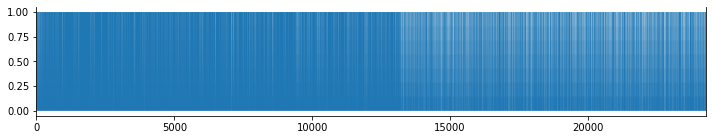

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)
plt.show()

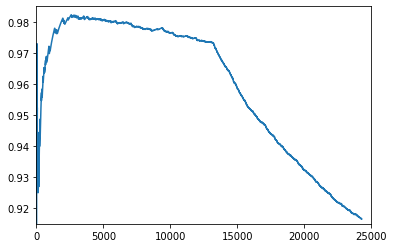

In [28]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985])
plt.show()

- plt.axis의 매개변수 조정을 통해 Glove에 없는 단어가 그렇지 않은 단어보다 많아지는
- 변곡점을 찾을 수 있습니다. 이 지점이 어휘 사전의 크기를 결정하는데 좋은 출발점입니다.

In [29]:
vocab_size = 13200
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [34]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          330000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 50)         10200     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                1224      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 356,649
Trainable params: 26,649
Non-tra

In [35]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 87s 106ms/step - loss: 0.6933 - accuracy: 0.5143 - val_loss: 0.6885 - val_accuracy: 0.5683
Epoch 2/30
719/719 [==============================] - 79s 110ms/step - loss: 0.6854 - accuracy: 0.5599 - val_loss: 0.6824 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 71s 99ms/step - loss: 0.6800 - accuracy: 0.5599 - val_loss: 0.6769 - val_accuracy: 0.5710
Epoch 4/30
719/719 [==============================] - 70s 97ms/step - loss: 0.6732 - accuracy: 0.5693 - val_loss: 0.6698 - val_accuracy: 0.5851
Epoch 5/30
719/719 [==============================] - 71s 99ms/step - loss: 0.6642 - accuracy: 0.6024 - val_loss: 0.6607 - val_accuracy: 0.6139
Epoch 6/30
719/719 [==============================] - 71s 99ms/step - loss: 0.6529 - accuracy: 0.6344 - val_loss: 0.6502 - val_accuracy: 0.6460
Epoch 7/30
719/719 [==============================] - 72s 100ms/step - loss: 0.6401 - accuracy: 0.6546 - val_loss: 0.6391 - val_accura

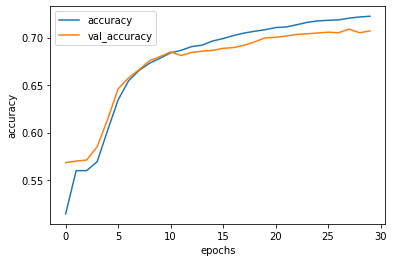

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

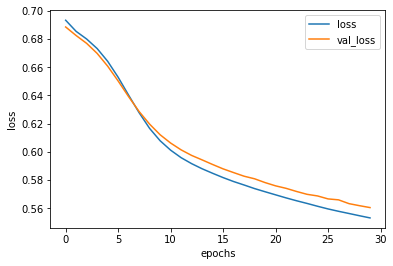

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [38]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
predictions = model.predict(padded)
print(predictions)

1/1 [==============================] - 3s 3s/step
[[0.5056641 ]
 [0.19495662]
 [0.7933753 ]
 [0.75621367]]


#### 추가로 공부가 필요한 내용
- LSTM에 대한 논문 읽어볼 것, 다양한 LSTM 종류
- 사전훈련된 임베딩에는 어떤 것들이 존재하는지
